In [49]:
import numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.fft import fft, ifft
from skimage.transform import radon, iradon, rotate

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

# Analytic Reconstruction Methods:

An object with an unknown attenuation $\mu(x,y)$ can be scanned in multiple positions. It is known that $$I=I_0e^{-\int \mu(x,y)\,ds}$$ where
- $ds$ is an elemental line through the object.
- $I_0$ and $I$ are both intensities of incident photons, of which $I_0$ is a partcular standard constant one. 
$$\ln \bigg(\frac{I_0}{I}\bigg)=\int \mu(x,y)\,ds$$ 
We'll call $ln(I_0/I) \equiv \rho(r,\theta)$ where 
- $\theta$ represents the tilt of the scanner
- $r$ represents the horizontal location on the scanner.

In [33]:
image = np.ones([100, 100])

diag = len(np.diag(image) // 2)
image = np.pad(image, pad_width = diag + 10)

In [34]:
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv - 0.1) ** 2 + (yv - 0.2) ** 2 < 0.01] = 2

image_rot = rotate(image, 45)

Text(0.5, 1.0, 'Rotated')

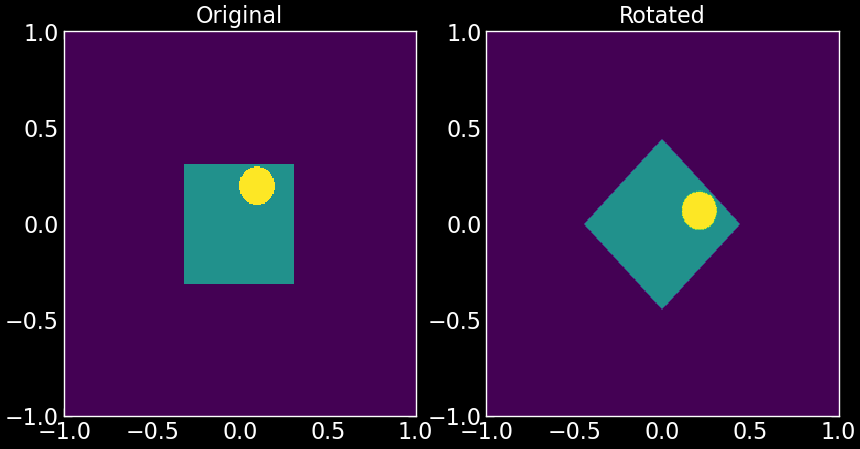

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].pcolor(xv, yv, image, shading = 'auto')
ax[1].pcolor(xv, yv, image_rot, shading = 'auto')

ax[0].set_title('Original')
ax[1].set_title('Rotated')

In [36]:
theta_values = np.arange(0, 180, 5) * np.pi / 180
r_values = _

dtheta = np.diff(theta_values)[0]
rotations = np.array([rotate(image, theta * 180 / np.pi) for theta in theta_values])

Text(0, 0.5, '$\\ln(I_0/I)$')

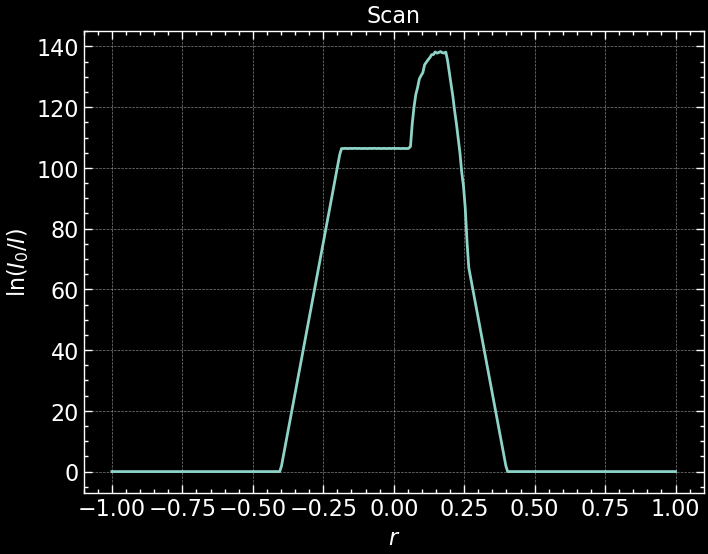

In [37]:
rho = np.array([rotation.sum(axis = 0) for rotation in rotations]).T

plt.plot(r_values, rho[:, 4])

plt.title('Scan')
plt.xlabel(r'$r$')
plt.ylabel(r'$\ln(I_0/I)$')

Text(0, 0.5, '$r$')

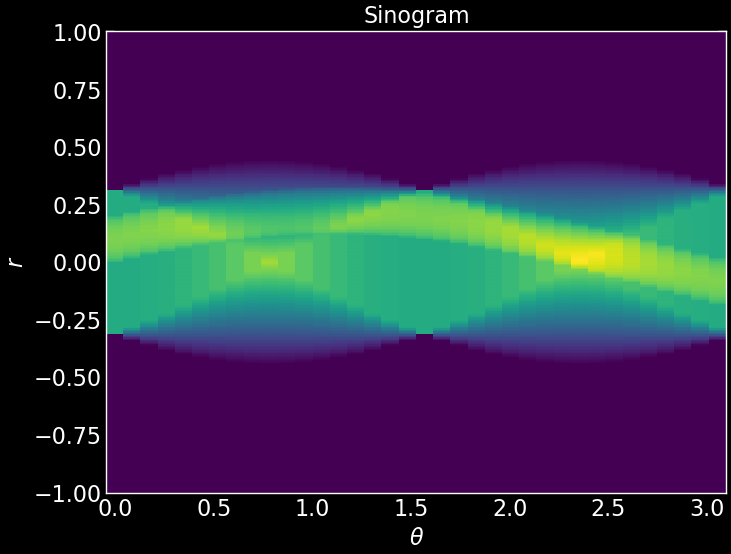

In [38]:
plt.pcolor(theta_values, r_values, rho, shading = 'auto')

plt.title('Sinogram')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')

# Regular Back Projection:

For a scan at an angle $\theta$, the value of $r$ that the point $(x,y)$ contributes is $x \cos\theta+y \sin\theta$ $$\mu_{BP}(x,y)=\int_0^\pi \rho(x \cos\theta+y \sin\theta, \theta)\,\theta \approx \sum_i \rho(x \cos\theta_i+y \sin\theta_i, \theta_i)\,\delta \theta_i$$

In [39]:
rho_interp = RectBivariateSpline(r_values, theta_values, rho)

def mu_BP(x, y):
    return rho_interp(x * np.cos(theta_values) + y * np.sin(theta_values), theta_values, grid = False).sum() * dtheta

Text(0.5, 1.0, 'Regularly Back-Projected Image')

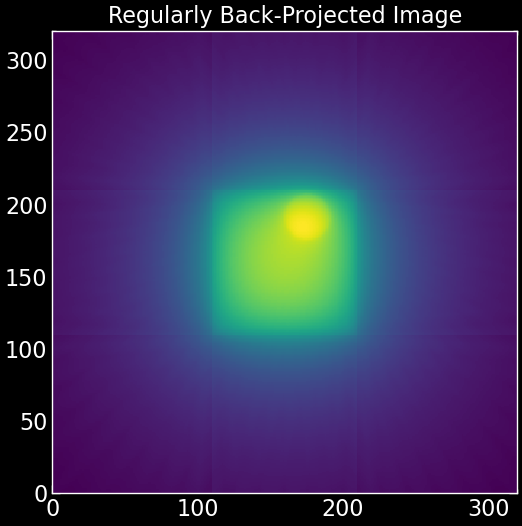

In [40]:
plt.figure(figsize = (6, 6))
plt.pcolor(np.vectorize(mu_BP)(xv, yv))
plt.title('Regularly Back-Projected Image')

# Filtered Back Projection:

The Filtered Back Projection makes use of Fourier Domain information:
- $\mu(x,y)$ has a 2-D Fourier Transform $$\Mu(\nu_x, \nu_y)=\iint \mu(x,y)\,e^{i2\pi\nu_x x}e^{i2\pi\nu_y y}\,dxdy$$
- $\rho(r,\theta)$ has a 1-D Fourier Transform $$\Rho(\nu, \theta)=\int \rho(r, \theta)\,e^{i2\pi \nu r}\,dr$$

It follows that $$\Mu(\nu \cos \theta, \nu \sin \theta)=\iint \mu(x,y)\,e^{i2\pi r\nu \cos \theta}\,e^{i2\pi r\nu \sin \theta}\,dxdy$$
Let $r=x \cos \theta + y  \sin \theta$ and $t=-x \cos \theta+y \sin \theta$. Then: $$\Mu(\nu \cos \theta, \nu \sin \theta)=\iint \mu(x,y)\,e^{i2\pi r\nu}\,drdt$$ $$=\int \rho(r, \theta)\,e^{i2\pi r\nu}\,dr$$ $$=\Rho(\nu, \theta)$$
So: $$\Mu(\nu \cos \theta, \nu \sin \theta)=\Rho(\nu,\theta)$$

In [41]:
Rho = fft(rho, axis = 0)
nu = np.fft.fftfreq(Rho.shape[0], d = np.diff(r_values)[0])

In [45]:
integrand = Rho.T * np.abs(nu)
integrand  = integrand.T

rho_prime = np.real(ifft(integrand, axis = 0))

Text(0.5, 1.0, 'Filtered Back Projected Image')

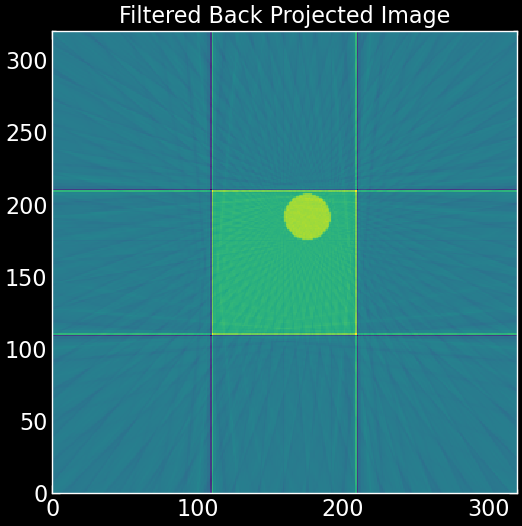

In [46]:
rho_prime_interp = RectBivariateSpline(r_values, theta_values, rho_prime)

def get_mu(x,y):
    return rho_prime_interp(x * np.cos(theta_values) + y * np.sin(theta_values), theta_values, grid = False).sum() * dtheta

mu = np.vectorize(get_mu)(xv, yv)

plt.figure(figsize = (6, 6))
plt.pcolor(mu)
plt.title('Filtered Back Projected Image')

# From *skimage* Libraries:

Text(0, 0.5, '$r$')

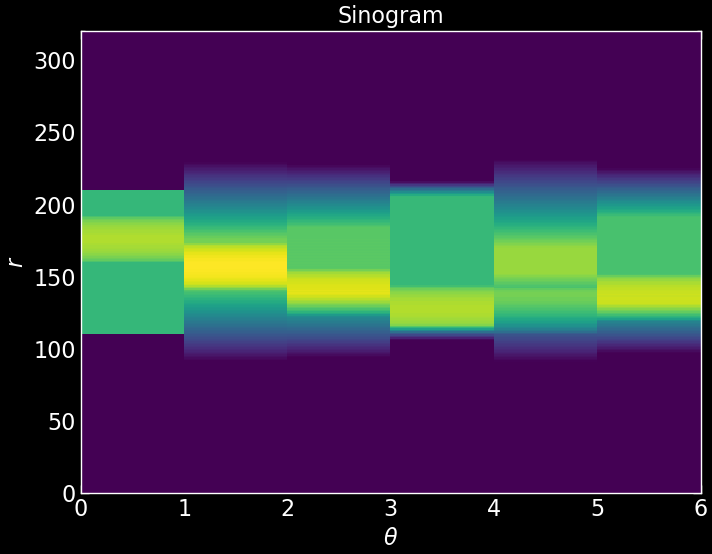

In [47]:
theta = np.arange(0., 180., 32)
sinogram = radon(image, theta = theta)

plt.pcolor(sinogram)

plt.title('Sinogram')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')

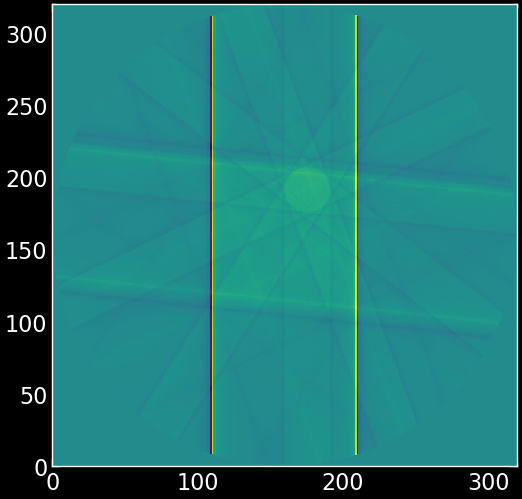

In [50]:
reconstruction_img = iradon(sinogram, theta = theta, filter_name = 'ramp')

plt.figure(figsize = (6, 6))
plt.pcolor(reconstruction_img)